<a href="https://colab.research.google.com/github/gbucci/RNASeq/blob/master/ColabMainRNAKallisto_v_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using the notebook
Note that the notebook is divided in *TEXT* and `CODE` blocks.

The `CODE` blocks (shaded in grey) also have a *RUN* button on the left side, which cause the `code block` to be executed. Once the spinnin' wheel stops user can procede to the next code block.
1. clicking on the |> *RUN* icon on the upper left in code block, will cause the code execution.
2. clicking on the X *clear output* on the left , will clean the dash area.

#Grant access to your gDrive space

By running this cell, you will be asked to click on a link to have access to your gDrive disk space (to permanently store the results)
- Click on it: a new page opens
- Click on the bottom button to enter you gDrive password.
- Copy the authorization code
- Go back to the notebook and paste the code
- Click enter

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/

---
#Identify SRA Accession in The Scientific Article 
---
### [Interferon-γ regulates cellular metabolism and mRNA translation to potentiate macrophage activation](https://www.ncbi.nlm.nih.gov/pubmed/26147685).

Original raw data are deposited on a public repository.
In this case files are stored in SRA format in the corresponding [NCBI database](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE66810)


>If you follow the above link you should see where the original data have been deposited. 

Indeed Scientific journals require that the raw data are made available to public and hosted on a dedicated platform: EBI, GEO, SRA etc...

>*We are interested in the follwing SRA objects from the original article*



SRP056098|Mock RNA | IFNg RNA
---|--- | ---
`replicate 1`|SRR1910733 | SRR1910734
`replicate 2`| SRR1910737 | SRR1910738



---
#Obtaining  FASTQ files

---
As previously mentioned, FASTQ are stored as SRA files, we have to:
1. access to SRA samples 
2. convert to FASTQ
---
We need fastq-dump from the NCBI's utility collection.

The following code chunk will get the software we need directly from NCBI FTP site.

*Run the cell to execute the code*.



In [0]:
#1
#the tool to convert is included in the package sratoolkit
! wget http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
#the package is gzipped and packed with tar
#un-tar and un-gzipp the package
! tar -zxvf sratoolkit.current-ubuntu64.tar.gz
! rm -rf sample_data/

###Test
To test the tool we will ask to extract the first two cluster from the FASTQ. 

The operation is done ***'on-the-fly'*** by querying SRA archive and retrieving the contents directly in FASTQ format.


In [0]:
#test the tool
! sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump --stdout -X 2 SRR1910733
#remove the tar package no longer needed
! rm sratoolkit.current-ubuntu64.tar.gz


---
#Inspect FASTQ from experiment SRP056098
---
To do this action we must provide fastq-dump with the four accession ID (SRR...) for the two replicate condition IFNg and Mock.

We can inspect the first two cluster for each of the sample, by printing it on screen.

Take some time to understand the structure of theese files. You should be able to identify ***nucleic acid sequence*** and the corresponding sequence ***Phred Score*** in ASCII text.

In [0]:
! sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump -X 2 --stdout  SRR1910733 #Mock RNA - replicate 1
! sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump -X 2 --stdout  SRR1910734 #IFNg RNA - replicate 1
! sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump -X 2 --stdout  SRR1910737 #Mock RNA - replicate 2
! sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump -X 2 --stdout  SRR1910738 #IFNg RNA - replicate 2


---
#Save FASTQ on local runtime disk

The next code will download a subset of 4M reads from each sample to the remote disk. 

***The operation should take from 8 to 15 minutes depending on network load.***




While files are processed take a look at this comics, which will introduce us to the concept of significance in hypotesis testing.
[XKCD Significant](https://xkcd.com/882/)

In [0]:
! time sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump --gzip -N 1000000 -X 5000000 -O FASTQ  SRR1910733 #Mock RNA - replicate 1
! time sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump --gzip -N 1000000 -X 5000000 -O FASTQ  SRR1910734 #IFNg RNA - replicate 1
! time sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump --gzip -N 1000000 -X 5000000 -O FASTQ  SRR1910737 #Mock RNA - replicate 2
! time sratoolkit.2.9.6-1-ubuntu64/bin/fastq-dump --gzip -N 1000000 -X 5000000 -O FASTQ  SRR1910738 #IFNg RNA - replicate 2 

---
#Transcript Abundance quantification
---
Now that we have the raw data on the disk, we can take the next step to quantify transcript abundance from sequenced reads.

We will adopt a procedure termed ***Pseudo-Alignment*** that will rely on a transcriptome index to assign sequence reads to transcripts (and gene).

*You can find more detail on the* [Kallisto web page](https://pachterlab.github.io/kallisto/about)



###Download and install **Kallisto**


In [0]:
!wget https://github.com/pachterlab/kallisto/releases/download/v0.46.0/kallisto_linux-v0.46.0.tar.gz
!tar -xf kallisto_linux-v0.46.0.tar.gz
!cp -nv kallisto/kallisto /usr/local/bin/


###Download **reference** fasta and GTF files

**The operation should take around 3 minutes.**

In [0]:
! time wget https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/ensembl-96/homo_sapiens.tar.gz
! time tar --overwrite -xvf homo_sapiens.tar.gz
#! time cp homo_sapiens.tar.gz /content/gdrive/My\ Drive/Colab\ Notebooks/

###Check the downloaded files

In [0]:
! ls 


FASTQ	      homo_sapiens.tar.gz	     sratoolkit.2.9.6-1-ubuntu64
gdrive	      kallisto
homo_sapiens  kallisto_linux-v0.46.0.tar.gz


###Build the index
We can now create an index from the fasta genome


`#Not Run`

`time kallisto index -i Homo_sapiens.GRCh38.cdna.all.idx -k 31 Homo_sapiens.GRCh38.cdna.all.fa`

Since it is a computational intensive step
we prefer to use the ***precomputed index*** we prepared for this class.

In [0]:
#make a link to index in the current directory
! ln -s  homo_sapiens/* .

###Start quantifying abundaces with Kallisto Quant

**The operation should take between 6 to 8 minutes to process 16M reads**

In [0]:
!time kallisto quant --plaintext --single -l 150 -s 15 -i transcriptome.idx -g Homo_sapiens.GRCh38.96.gtf -t 2 -o SRR1910733_out/ FASTQ/SRR1910733.fastq.gz
!time kallisto quant --plaintext --single -l 150 -s 15 -i transcriptome.idx -g Homo_sapiens.GRCh38.96.gtf -t 2 -o SRR1910734_out/ FASTQ/SRR1910734.fastq.gz
!time kallisto quant --plaintext --single -l 150 -s 15 -i transcriptome.idx -g Homo_sapiens.GRCh38.96.gtf -t 2 -o SRR1910737_out/ FASTQ/SRR1910737.fastq.gz
!time kallisto quant --plaintext --single -l 150 -s 15 -i transcriptome.idx -g Homo_sapiens.GRCh38.96.gtf -t 2 -o SRR1910738_out/ FASTQ/SRR1910738.fastq.gz

### ***optional*** copy the abundance results to gDrive

In [0]:
!cp -rnv SRR*_out /content/gdrive/My\ Drive/Colab\ Notebooks/

### ***optional*** copy the abundance results to local drive

In [0]:
! mkdir KallistoResults 
! cp -R SRR*out KallistoResults
! tar -zcvf KallistoResults.tar.gz KallistoResults

In [0]:
from google.colab import files

files.download('KallistoResults.tar.gz')

#Inspect Abundance files

We can take a quick look of the output we've generated in the previous step.

For each fastq a directory have been created.

In each directory we can list three files:
- abundance.tsv
- run_info.json

In [0]:
!ls *_out/

SRR1910733_out/:
abundance.tsv  run_info.json

SRR1910734_out/:
abundance.tsv  run_info.json

SRR1910737_out/:
abundance.tsv  run_info.json

SRR1910738_out/:
abundance.tsv  run_info.json


###Create a single TSV file that has the TPM abundance estimates for all four samples

This chunk of code grabs all the 'abundance' files from the previous quantification step and put them in a single huge table with all the transcripts from the four samples.

In [0]:
! paste *_out/abundance.tsv | cut -f 1,2,5,10,15,20 > transcript_tpms_all_samples.tsv
! ls -1 *_out/abundance.tsv | perl -ne 'chomp $_; if ($_ =~ /(\S+)\/abundance\.tsv/){print "\t$1"}' | perl -ne 'print "target_id\tlength$_\n"' > header.tsv
! cat header.tsv transcript_tpms_all_samples.tsv | grep -v "tpm" > transcript_tpms_all_samples.tsv2
! mv transcript_tpms_all_samples.tsv2 transcript_tpms_all_samples.tsv
! rm -f header.tsv

In [0]:
#copy on gDrive
! cp transcript_tpms_all_samples.tsv /content/gdrive/My\ Drive/Colab\ Notebooks/

###Take a look at the final kallisto result file we created:

In [0]:
! head transcript_tpms_all_samples.tsv
! sort -nr -k 4 transcript_tpms_all_samples.tsv| head


target_id	length	SRR1910733_out	SRR1910734_out	SRR1910737_out	SRR1910738_out
ENST00000631435.1	12	0	0	0	0
ENST00000434970.2	9	0	0	0	0
ENST00000448914.1	13	0	0	0	0
ENST00000415118.1	8	0	0	0	0
ENST00000632684.1	12	0	0	0	0
ENST00000604446.1	23	0	0	0	0
ENST00000603693.1	19	0	0	0	0
ENST00000603935.1	31	0	0	0	0
ENST00000604102.1	31	0	0	0	0
ENST00000273550.12	1203	35071.7	33599.6	35953.1	28500.6
ENST00000331825.11	871	35652.2	29029.5	27520.1	29731.3
ENST00000233143.6	461	4522.48	12731.2	4916.07	9682.83
ENST00000451311.7	622	10286.6	11633.2	9823.89	8376.4
ENST00000245185.6	401	3429.07	10955.9	1927.9	7757.63
ENST00000613922.2	780	6496.69	10401.2	4578.13	19315
ENST00000464611.1	715	22372.8	9720.56	16246.1	3782.5
ENST00000361739.1	684	8764.09	8912.25	6787.88	6697.86
ENST00000307407.8	1642	3500.49	8655.85	3229.77	16856.8
ENST00000621600.4	667	5940	8482.88	5310.27	15921


#Differential analysis with R

##Prepare environment and install needed packages

>we will see several warnings during installation.
>>we expect it and we can ignore them.

###Load python package to interpret R commands

In [0]:
%load_ext rpy2.ipython

###Load R environment and use BiocInstall to retrieve *limma* and *tximport*

In [0]:
%%R
ow<-options("warn")
options(warn = -1)
install.packages("BiocManager")
options(warn = -1)
BiocManager::install(c("limma","tximport"),update=FALSE,checkBuilt=FALSE)

###Use bash interface to R to install required package 

In [0]:
! wget https://cran.r-project.org/src/contrib/locfit_1.5-9.1.tar.gz
! wget https://bioconductor.org/packages/release/bioc/src/contrib/edgeR_3.28.0.tar.gz
! wget https://cran.r-project.org/src/contrib/statmod_1.4.32.tar.gz

! R CMD INSTALL locfit_1.5-9.1.tar.gz
! R CMD INSTALL statmod_1.4.32.tar.gz
! R CMD INSTALL edgeR_3.28.0.tar.gz

##DGE Analysis

###Load packages in R

In [0]:
%%R
library("limma")
library("tximport")
library("edgeR")
sessionInfo()

###create sample data frame

In [0]:
%%R
samples <- data.frame(Sample=matrix(c("SRR1910733","SRR1910734","SRR1910737","SRR1910738")),
Treatment=matrix(c("Mock","IFNg","Mock","IFNg")))

samples$Treatment <- as.factor(samples$Treatment)
samples$Treatment <- relevel(samples$Treatment,ref="Mock")


###import counts and gene table

In [0]:
%%R
tx2gene <- read.table("transcripts_to_genes.txt")
head(tx2gene)
#define were are the transcript abundances computed with Kallisto
files <- file.path(paste(samples$Sample,"out",sep="_"), "abundance.tsv")
names(files) <- samples$Sample
files
all(file.exists(files))
#use tximport to read in the transcript abundances computed with Kallisto
txi <- tximport(files, type = "kallisto", tx2gene = tx2gene[,1-3], txOut = FALSE,countsFromAbundance="lengthScaledTPM")
dir<-getwd()
#create a contrast matrix
design<-model.matrix(~Treatment, data=samples)
design


###Inspect global counts statistics

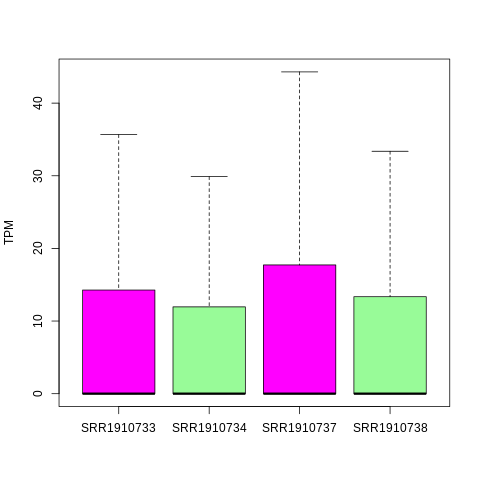

In [0]:
%%R
names(txi)
summary(txi$counts)
boxplot((txi$counts),outline=FALSE,col=c("magenta","palegreen"),ylab=("TPM"))


###Create the DGEList object and normalize and using *limma voom*

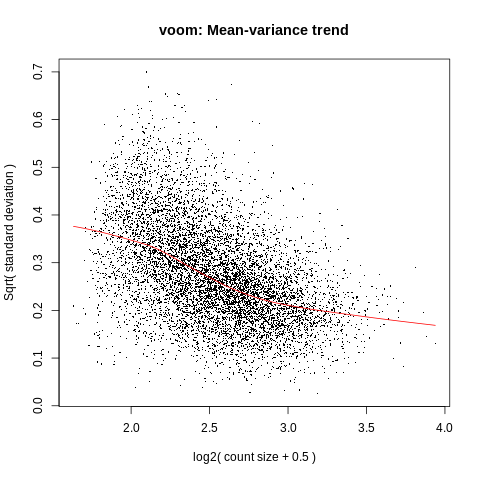

In [0]:
%%R
y<-DGEList(txi$counts)
  y$genes<-tx2gene
#select only informative genes  
  keep <- filterByExpr(y)
#transform in log2 Count per Million
y <- cpm(y[keep,],log=TRUE)
  n<-calcNormFactors(y,method = "RLE")
#Transform RNA-Seq Data Ready for Linear Modelling
v <- voom(y, design, plot=TRUE)

###Plot expression statistics and samples Multi Dimensional Scaling 

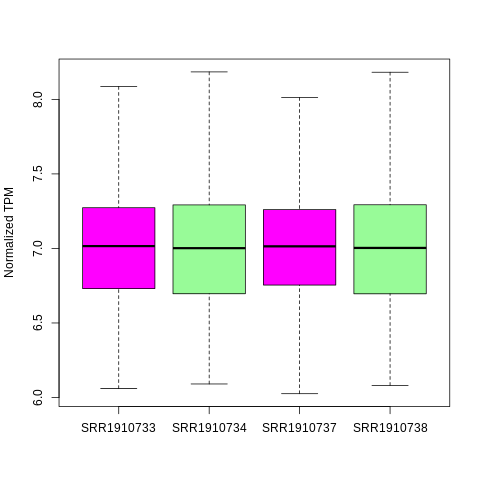

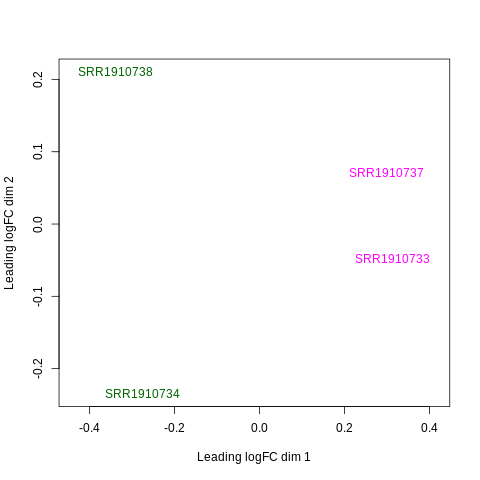

In [0]:
%%R
boxplot((v$E),outline=FALSE,col=c("magenta","palegreen"),ylab=("Normalized TPM"))
MDS<-plotMDS(v$E,col=c("magenta","darkgreen"))


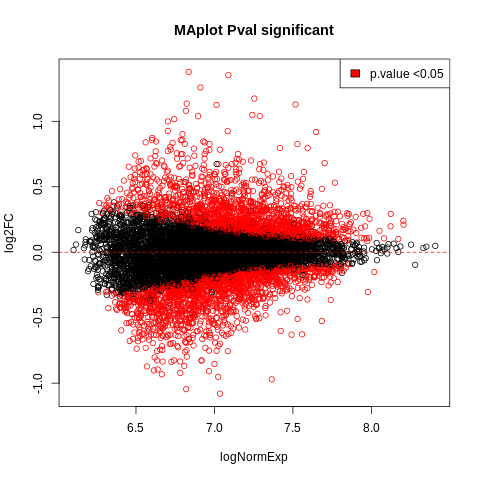

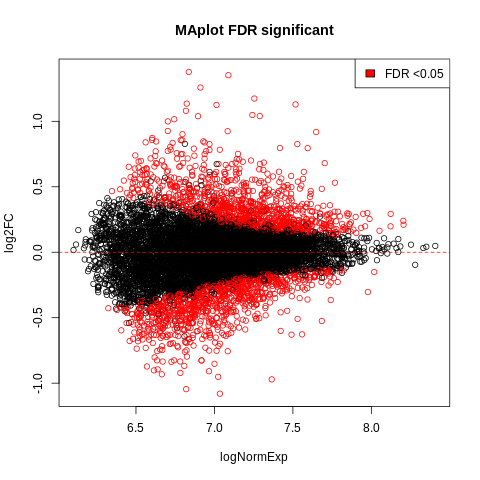

In [0]:
%%R
# Now we use the voom (log-norm transformed abundances) to produce linear models
# using the design. In this way we will have also the coefficients (logFC) for 
# our design
fit <- lmFit(v, design)
# And use the Bayesian function to estimate variance, robustly and have the
# p.values calculated
fit <- eBayes(fit, robust=TRUE)
fit$genes <- tx2gene
## End(Not run)
## The topTable function will produce a table with the results of the DEG, that
## we could filter with our favourite cut offs, of either p.value, FDR (p.adj 
## with method "BH")
## or log2FC
#help(topTable)
top.Table <- topTable(fit,number=Inf,adjust.method="BH", p.value=0.05,
                      genelist=fit$genes)

full.Table <- topTable(fit,number=Inf,adjust.method="BH", p.value=1,
                      genelist=fit$genes)

# Save the table in csv
write.table(top.Table,file="TopTable.csv",sep=";",row.names=TRUE,col.names=T,quote=F)
write.table(full.Table,file=gzfile("FullTable.csv.gz"),sep=";",row.names=TRUE,col.names=T,quote=F)

p.value.cutoff = 0.05
sigs.pval = ifelse(fit$p.value[,"TreatmentIFNg"] <= p.value.cutoff, "red","black")
sigs.fdr = ifelse(p.adjust(fit$p.value[,"TreatmentIFNg"],"BH") < p.value.cutoff,"red","black")


plot(main="MAplot Pval significant",
     x=fit$Amean,
     y=fit$coefficient[,2],
     xlab="logNormExp",ylab="log2FC",col=sigs.pval,cex=1)
abline(h=0,lty=2,col="red")
legend("topright",legend=c(paste0("p.value <",p.value.cutoff)),fill=c("red","black"))

plot(main="MAplot FDR significant",
     x=fit$Amean,
     y=fit$coefficient[,2],
     xlab="logNormExp",ylab="log2FC",col=sigs.fdr,cex=1)
abline(h=0,lty=2,col="red")
legend("topright",legend=c(paste0("FDR <",p.value.cutoff)),fill=c("red","black"))



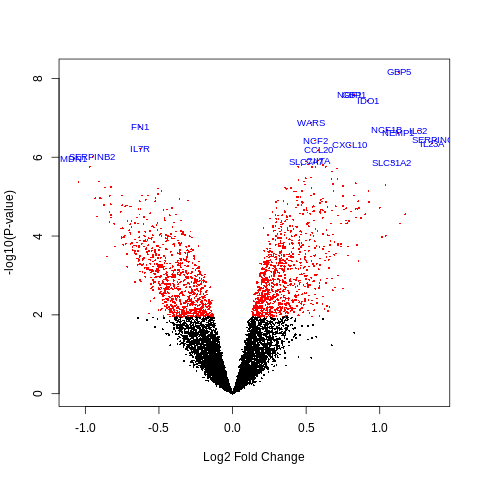

In [0]:
%%R
volcanoplot(fit,coef="TreatmentIFNg",col=sigs.fdr,highlight=20,names=row.names(fit))


###Copy the table of results on gDrive for further usage

In [0]:
! cp TopTable.csv /content/gdrive/My\ Drive/Colab\ Notebooks/
! cp FullTable.csv.gz /content/gdrive/My\ Drive/Colab\ Notebooks/


###Save the table of results on gDrive for further usage

In [0]:
from google.colab import files

files.download('TopTable.csv')
files.download('FullTable.csv.gz')
